In [1]:
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from mpl_toolkits.mplot3d import Axes3D

import torch
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes

print(torch.__version__)

1.9.0+cu111


- Parser

In [2]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--obj_path', help='input mesh data (obj) path',
        default='./processed/zilla_night_black_heat/textured_meshes/optimized_poisson_texture_mapped_mesh.obj') # Dataset: BigBIRD
    parser.add_argument('--sampling_size', help='points sampling size', type=int, 
        default=5000)
                        
    args = parser.parse_args(args=[])

    return args

args = parse_args()

- Device

In [3]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print('device:', device)

device: cuda:0


- Build Meshes

In [4]:
# Load mesh data with object format
verts, faces, aux = load_obj(args.obj_path)

faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Build Meshes class
mesh = Meshes(verts=[verts], faces=[faces_idx])

- Mesh to point cloud (sampling points)

In [5]:
# Sample points uniformly from the surface of the mesh.
"""
Convert a batch of meshes to a batch of pointclouds by uniformly sampling
points on the surface of the mesh with probability proportional to the
face area.

Args:
    meshes: A Meshes object with a batch of N meshes.
    num_samples: Integer giving the number of point samples per mesh.
    return_normals: If True, return normals for the sampled points.
    return_textures: If True, return textures for the sampled points.

Returns:
    3-element tuple containing

    - **samples**: FloatTensor of shape (N, num_samples, 3) giving the
      coordinates of sampled points for each mesh in the batch. For empty
      meshes the corresponding row in the samples array will be filled with 0.
    - **normals**: FloatTensor of shape (N, num_samples, 3) giving a normal vector
      to each sampled point. Only returned if return_normals is True.
      For empty meshes the corresponding row in the normals array will
      be filled with 0.
    - **textures**: FloatTensor of shape (N, num_samples, C) giving a C-dimensional
      texture vector to each sampled point. Only returned if return_textures is True.
      For empty meshes the corresponding row in the textures array will
      be filled with 0.

    Note that in a future releases, we will replace the 3-element tuple output
    with a `Pointclouds` datastructure, as follows

    .. code-block:: python

        Pointclouds(samples, normals=normals, features=textures)
    """
points = sample_points_from_meshes(mesh, args.sampling_size)

- Plot point cloud

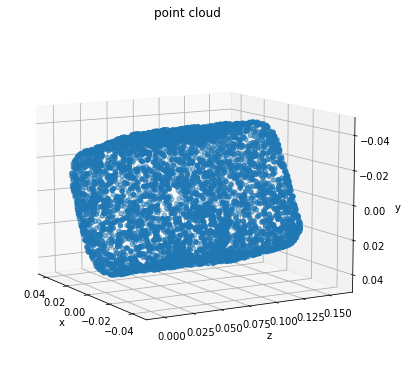

In [6]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

plot_pointcloud(points, "point cloud")